In [1]:
#https://www.tensorflow.org/tutorials/keras/text_classification

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras

!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.0.0


In [3]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to C:\Users\tyu-dev\tensorflow_datasets\imdb_reviews\subwords8k\0.1.0. Subsequent calls will reuse this data.


In [4]:
# dataset "info" includes the text encoder (a tfds.features.text.SubwordTextEncoder).
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
# encoder can/will reversibly encode any string:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
# encoder encodes the string by breaking it into subwords/characters if the word is not in it's dictionary
    # thus: the more a string resembles a dataset, the shorter the encoded representation will be
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [ ]:
# dataset is preprocessed - each example is array of int representing the words of the movie review content

In [ ]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

In [ ]:
# `info` structure contains the encoder/decoder ---> encoder can be used to recover the original text:
encoder.decode(train_example)

In [7]:
#prep data for training
    # each batch will have a shape of (batch_size,sequence_length) due to dynamic padding length for each batch
    # padded_batch is used to zero-pad the sequences while batching (due to the reviews being different lengths)
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32, train_data.output_shapes))

for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 1407)
label shape: (32,)
Batch shape: (32, 1349)
label shape: (32,)


The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

In [8]:
# build model
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
# train
history = model.fit(train_batches,
                    epochs=20, #10
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/20
782/782 [==============================].2482 - accuracy: 0.93 - 0s 52ms/step - loss: 0.2556 - accuracy: 0.93 - 0s 38ms/step - loss: 0.2326 - accuracy: 0.94 - 0s 30ms/step - loss: 0.2917 - accuracy: 0.92 - 0s 26ms/step - loss: 0.2772 - accuracy: 0.93 - 0s 23ms/step - loss: 0.2768 - accuracy: 0.92 - 0s 21ms/step - loss: 0.2830 - accuracy: 0.91 - 0s 20ms/step - loss: 0.2934 - accuracy: 0.91 - 0s 19ms/step - loss: 0.3062 - accuracy: 0.89 - 0s 18ms/step - loss: 0.3186 - accuracy: 0.89 - 0s 17ms/step - loss: 0.3161 - accuracy: 0.89 - 0s 16ms/step - loss: 0.3261 - accuracy: 0.88 - 0s 16ms/step - loss: 0.3230 - accuracy: 0.89 - 0s 15ms/step - loss: 0.3198 - accuracy: 0.89 - 0s 15ms/step - loss: 0.3242 - accuracy: 0.89 - 0s 15ms/step - loss: 0.3200 - accuracy: 0.89 - 0s 14ms/step - loss: 0.3192 - accuracy: 0.89 - 0s 14ms/step - loss: 0.3184 - accuracy: 0.89 - 0s 14ms/step - loss: 0.3132 - accuracy: 0.89 - 0s 14ms/step - loss: 0.3130 - accuracy: 0.89 - 0s 13ms/step - loss: 0.3067 - a

In [20]:
# evaluate model
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================].3044 - accuracy: 0.84 - 0s 16ms/step - loss: 0.3076 - accuracy: 0.87 - 0s 13ms/step - loss: 0.2991 - accuracy: 0.88 - 0s 11ms/step - loss: 0.2994 - accuracy: 0.89 - 0s 10ms/step - loss: 0.2892 - accuracy: 0.88 - 0s 9ms/step - loss: 0.2958 - accuracy: 0.8802 - 0s 9ms/step - loss: 0.2875 - accuracy: 0.883 - 0s 8ms/step - loss: 0.3031 - accuracy: 0.875 - 0s 8ms/step - loss: 0.3125 - accuracy: 0.875 - 0s 8ms/step - loss: 0.3013 - accuracy: 0.881 - 0s 8ms/step - loss: 0.3162 - accuracy: 0.872 - 0s 8ms/step - loss: 0.3104 - accuracy: 0.872 - 0s 7ms/step - loss: 0.3147 - accuracy: 0.872 - 0s 7ms/step - loss: 0.3160 - accuracy: 0.875 - 0s 7ms/step - loss: 0.3130 - accuracy: 0.877 - 0s 7ms/step - loss: 0.3274 - accuracy: 0.875 - 0s 7ms/step - loss: 0.3225 - accuracy: 0.875 - 0s 7ms/step - loss: 0.3193 - accuracy: 0.878 - 0s 7ms/step - loss: 0.3265 - accuracy: 0.876 - 0s 7ms/step - loss: 0.3172 - accuracy: 0.879 - 0s 7ms/step - loss: 0.3135 - accuracy: 0.

In [21]:
# visualize accuracy/loss over time
history_dict = history.history
history_dict.keys()

# loss,accuracy,validation loss and validation accuracy are all metrics monitored/recorded during training

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

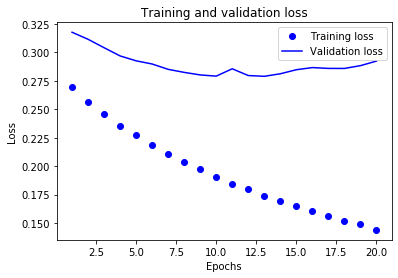

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

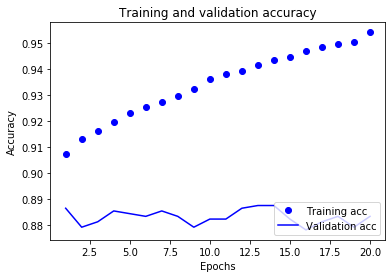

In [23]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
# training loss decrases with each epoch and accuracy increases ===> expected when using SGD
# validation loss and accuracy peak after about 10-20 epochs ---> example of overfitting